In [172]:
import sympy as sp
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats, optimize

### 1. Equação 1

$$
E_l(f) = 0.125 C_T^2 f_l^{-5/3}
$$

**Explicação**:
- Esta equação descreve a densidade espectral de energia das flutuações de temperatura do ar em função da frequência $fd$.
- **$C_Td$** é o parâmetro de estrutura das flutuações de temperatura do ar.
- **$f_ld$** é a escala espacial na faixa espectral de pequenas escalas.
- Utilizada para modelar a turbulência atmosférica em pequena escala baseada na teoria de Kolmogorov.


Para calcular o $C_T^2$ utilizando os dados de reanálise de perfil vertical do ERA5 foram utilizados os dados de temperatura em 11 níveis de pressão: 1hPa, 100hPa, 200hPa, 300hPa, 400hPa, 500hPa, 600hPa, 700hPa, 800hPa, 900hPa, 1000hPa.

#### 1.1. Cálculo de $C_T^2d$

O parâmetro de estrutura da temperatura, $C_T^2d$, pode ser estimado a partir dos gradientes verticais de temperatura. A equação empírica para calcular $C_T^2d$ é dada por:

$$
C_T^2 = \beta \left(\frac{\partial T}{\partial z}\right)^2
$$

**Explicação**:
- **$\frac{\partial T}{\partial z}d$**: Representa o gradiente vertical de temperatura, que indica a taxa de mudança da temperatura com a altitude.
- **$\beta$**: É um coeficiente empírico que precisa ser ajustado com base em dados experimentais ou referências da literatura. Este coeficiente reflete as características da turbulência atmosférica e outras condições locais.


In [7]:
def spectral_energy_density(CT, fl):
    """
    Calculates the spectral energy density of air temperature fluctuations.

    Parameters:
    CT (float): Structure parameter of air temperature fluctuations.
    fl (float): Spatial scale in the spectral range of small scales.

    Returns:
    float: Spectral energy density.

    Description:
    This function computes the spectral energy density (E_l(f)) of air temperature fluctuations based 
    on the Kolmogorov theory of turbulence. The spectral energy density is a measure of how the energy 
    of temperature fluctuations is distributed across different spatial scales.

    The equation used for this calculation is:
    
    E_l(f) = 0.125 * CT^2 * fl^(-5/3)

    where:
    - CT is the structure parameter of temperature fluctuations, representing the intensity of 
      temperature variability in the atmosphere.
    - fl is the spatial scale in the spectral range of small scales, which typically corresponds 
      to high-frequency components in the turbulence spectrum.

    Example:
    To calculate the spectral energy density for a given structure parameter and spatial scale, 
    you can use the function as follows:

    >>> CT = 0.02  # Example structure parameter
    >>> fl = 10.0  # Example spatial scale
    >>> energy_density = spectral_energy_density(CT, fl)
    >>> print(energy_density)
    """
    
    return 0.125 * CT**2 * fl**(-5/3)


def calculate_CT2(vertical_profile, beta=0.1):
    """
    Calculate the structure parameter of temperature (C_T^2) based on vertical temperature gradients.

    Parameters:
    vertical_profile (xarray.Dataset): Dataset containing the temperature data and pressure levels.
    beta (float): Empirical coefficient used to estimate C_T^2 from the temperature gradient.

    Returns:
    xarray.DataArray: Computed C_T^2 values across the provided pressure levels.

    Description:
    This function computes the structure parameter of temperature, C_T^2, which is essential for 
    understanding atmospheric turbulence and its effects on temperature distribution. It is calculated 
    using the squared vertical temperature gradient multiplied by an empirical coefficient, beta.

    The temperature gradient is determined by the difference in temperature across successive pressure 
    levels, divided by the difference in those pressure levels. This gradient is then squared and 
    multiplied by beta to estimate C_T^2.

    Example:
    Assume you have a dataset 'ds' with temperature data across various pressure levels. You can 
    calculate C_T^2 using a beta value of 0.1 as follows:

    >>> ds = xarray.open_dataset("path_to_your_data.nc")
    >>> ct2 = calculate_CT2(ds, beta=0.1)
    >>> print(ct2)
    """
    # Calculate the vertical temperature gradient
    temperature_gradient = vertical_profile['temperature'].diff(dim='pressure_level') / vertical_profile['pressure_level'].diff(dim='pressure_level')

    # Estimate C_T^2
    ct2 = beta * temperature_gradient**2

    return ct2

### 2. Equação 2

$$
E_l(f) = E(f_L) \exp\left(\frac{-3}{5} \ln^2 \left(\frac{f_l}{f_t}\right)\right)
$$

**Explicação**:
- Modela a densidade espectral de energia para a faixa de alta frequência.
- **\(f_L\)** é a frequência da faixa de baixa frequência espacial.
- **\(f_t\)** é a frequência na região espectral de transição.
- Ajuda a entender a transição entre diferentes regimes de turbulência.

In [ ]:
def HF_spectral_energy_density(E_fL, fl, ft):
    """
    Calculates the spectral energy density for high-frequency ranges using an exponential decay model.

    Parameters:
    E_fL (float): Energy density at the low spatial frequency \(f_L\).
    fl (float): Spatial frequency of interest.
    ft (float): Transition frequency in the spectral region.

    Returns:
    float: Spectral energy density at the frequency \(fl\).

    Description:
    This function models the spectral energy density for high-frequency ranges by applying an 
    exponential decay function to the energy density at a lower spatial frequency. The model 
    helps in understanding the transition between different turbulence regimes by modifying 
    the distribution of energy density across the frequency spectrum.

    The equation used is:
    E_l(f) = E(f_L) * exp(-3 * ln^2(fl / ft))

    where:
    - E(f_L) is the energy density at the low spatial frequency \(f_L\).
    - fl is the spatial frequency where the energy density is being calculated.
    - ft is the transition frequency, marking the shift between different spectral regimes.
    
    Example:
    >>> E_fL = 0.5  # Example energy density at f_L
    >>> fl = 100.0  # Spatial frequency of interest
    >>> ft = 50.0   # Transition frequency
    >>> energy_density = spectral_energy_density(E_fL, fl, ft)
    >>> print(energy_density)
    """
    # Calculate the energy density using the given model
    return E_fL * np.exp((-3/5) * np.log(fl / ft)**2)

### 3. Equação 3

$$
f_T = 0.7 V f_L
$$

**Explicação**:
- Relaciona a frequência temporal de referência **\(f_T\)** com a frequência espacial **\(f_L\)** e a velocidade média do vento **\(V\)**.
- Utilizada para converter dados de frequência espacial para frequência temporal.


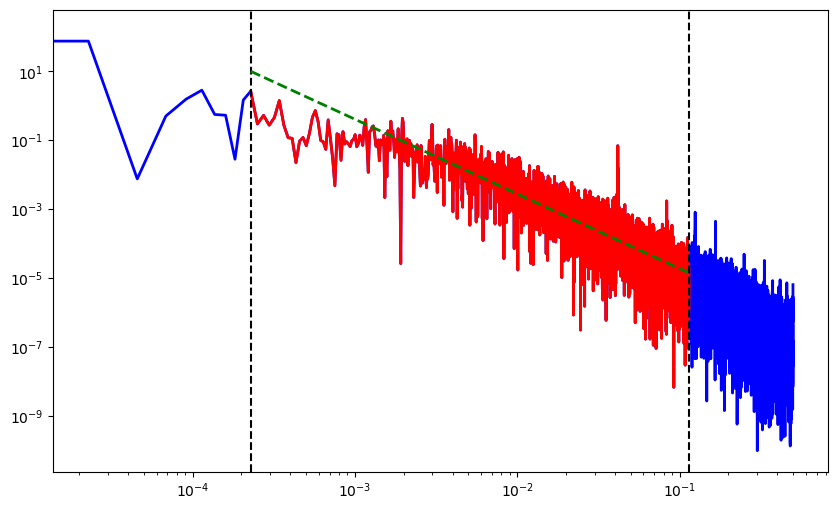

In [184]:
import matplotlib.mlab as mlab

data = wind_time
start_slope = 10
end_slope = 5000
time = np.arange(0, len(data), 1)

dt = (time[-1] - time[0]) / len(time)
f_s = 1 / dt

power, freqs = mlab.psd(data, NFFT=len(data), Fs=f_s, scale_by_freq=False)

total_freqs = len(freqs)
total_PSD = end_slope - start_slope
percentagem_PSD = int(total_PSD / total_freqs * 100)

x_data = freqs[start_slope:end_slope]
y_data = power[start_slope:end_slope]

# error simulation
yerr = 0.2 * y_data

# lambda function to calculater power law
power_law = lambda x, amp, index: amp * (x**index)

# convert x_data to log scale
x_data_log = np.log10(x_data)
y_data_log = np.log10(y_data)

# curve fit the data to the power law
fit_func = lambda p, x: p[0] + p[1] * x
err_func = lambda p, x, y, err: (y - fit_func(p, x)) / err
log_yerr = yerr / y_data

init = [1, -1]
out = optimize.leastsq(err_func, init, args=(x_data_log, y_data_log, log_yerr), full_output=1)
pfinal = out[0]
covar = out[1]
index = pfinal[1]
amp = 10.0**pfinal[0]
indexErr = np.sqrt(covar[1][1])*amp

# plot PSD
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(freqs, power, color='b', lw=2)
ax.plot(x_data, y_data, color='r', lw=2)
plt.axvline(x=freqs[start_slope], color='k', linestyle='--')
plt.axvline(x=freqs[end_slope], color='k', linestyle='--')
ax.plot(x_data, power_law(x_data, amp, index), color='g', linestyle='--', lw=2)
ax.set_yscale('log')
ax.set_xscale('log')








/tmp/ipykernel_158479/3646996730.py:15: RuntimeWarning: divide by zero encountered in power
  return amplitude * (x**index)
/tmp/ipykernel_158479/3646996730.py:35: RuntimeWarning: divide by zero encountered in power
  ref_slope = amplitude * (positive_freqs ** (-5/3))
/tmp/ipykernel_158479/3646996730.py:36: RuntimeWarning: divide by zero encountered in power
  f_3_slope = amplitude * (positive_freqs ** (-3))


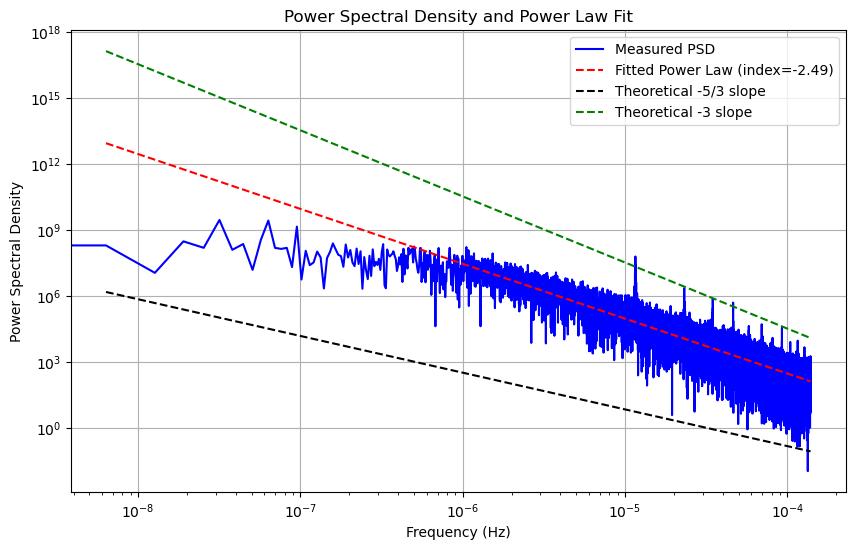

In [213]:


data = wind_time
samplitudeling_rate = 1/3600
fft_result = np.fft.fft(data)
freqs = np.fft.fftfreq(len(data), 1 / samplitudeling_rate)
positive_freqs = freqs[:len(freqs)//2]
psd = np.abs(fft_result[:len(freqs)//2])**2

f_L = positive_freqs[np.argmax(psd)]

f_T = 0.7*np.mean(data)*f_L


# Fit a power law to the data
def power_law(x, amplitude, index):
    return amplitude * (x**index)

# Only consider positive frequencies and non-zero values to avoid log(0)
valid_mask = (positive_freqs > 0)
log_freqs = np.log10(positive_freqs[valid_mask])
log_psd = np.log10(psd[valid_mask])

# Curve fit on log-log scale
popt, pcov = optimize.curve_fit(lambda x, a, b: a + b * x, log_freqs, log_psd)  
amplitude = 10**popt[0]
index = popt[1]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(positive_freqs, psd, label='Measured PSD', color='blue')
ax.loglog(positive_freqs, power_law(positive_freqs, amplitude, index), label=f'Fitted Power Law (index={index:.2f})', color='red', linestyle='--')
ax.set_title('Power Spectral Density and Power Law Fit')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power Spectral Density')

ref_slope = amplitude * (positive_freqs ** (-5/3))
f_3_slope = amplitude * (positive_freqs ** (-3))
ax.loglog(positive_freqs, ref_slope, 'k--', label='Theoretical -5/3 slope')
ax.loglog(positive_freqs, f_3_slope, 'g--', label='Theoretical -3 slope')

ax.legend()
ax.grid(True)
plt.show()

In [170]:
def calculate_fL(data):
    """
    Calculate the dominant frequency (f_L) from hourly wind data using FFT.

    Parameters:
    data (numpy.array): Array of hourly wind speed measurements.

    Returns:
    float: Dominant frequency (f_L) in cycles per hour.
    """
    fft_result = np.fft.fft(data)
    frequencies = np.fft.fftfreq(len(data), d=1)  # d=1 because the data is hourly
    positive_frequencies = frequencies[:len(frequencies)//2]
    magnitudes = np.abs(fft_result)[:len(frequencies)//2]
    
    # Finding the index of the maximum magnitude in the positive frequency part
    dominant_index = np.argmax(magnitudes)
    f_L = positive_frequencies[dominant_index]
    
    return f_L

def calculate_fL(time_serie, sample_rate):
    """
    Calculate the dominant spatial frequency (f_L) using Fast Fourier Transform (FFT).

    Parameters:
    time_serie (numpy.array): Array of values representing a time series of the variabe.

    Returns:
    float: The dominant spatial frequency (f_L) in cycles per unit distance.

    Description:
    This function applies FFT to an array to find the dominant frequency component.
    """
    # Apply FFT
    fft_result = np.fft.fft(data)
    frequencies = np.fft.fftfreq(len(data), d=sample_rate)

    # Find the index of the maximum amplitude in the positive frequencies part only
    positive_freqs = frequencies[:len(frequencies)//2]
    positive_fft = np.abs(fft_result)[:len(frequencies)//2]
    dominant_frequency_index = np.argmax(positive_fft)

    # Dominant spatial frequency
    f_L = abs(positive_freqs[dominant_frequency_index])

    return f_L


def calculate_fT(V, f_L):
    """
    Calculate the temporal frequency reference (f_T) based on the wind speed (V) and spatial frequency (f_L).

    Parameters:
    V (float): Average wind speed (m/s).
    f_L (float): Spatial frequency (Hz).

    Returns:
    float: Temporal frequency reference (f_T) in Hz.

    Description:
    This function computes the temporal frequency reference (f_T) using the relationship:
    
    f_T = 0.7 * V * f_L

    where:
    - V is the average wind speed in meters per second (m/s).
    - f_L is the spatial frequency in Hertz (Hz).

    Example:
    >>> V = 5.0  # Average wind speed in m/s
    >>> f_L = 0.1  # Spatial frequency in Hz
    >>> f_T = calculate_ft(V, f_L)
    >>> print(f_T)
    0.35
    """
    f_T = 0.7 * V * f_L
    return f_T

In [ ]:
data = wind_time

fft_result = np.fft.fft(data)
frequencies = np.fft.fftfreq(len(data), d=1)  # d=1 because the data is hourly
positive_frequencies = frequencies[:len(frequencies)//2]
magnitudes = np.abs(fft_result)[:len(frequencies)//2]

# Finding the index of the maximum magnitude in the positive frequency part
dominant_index = np.argmax(magnitudes)
f_L = positive_frequencies[dominant_index]

# plot the FFT result
plt.figure(figsize=(12, 6))
plt.plot(positive_frequencies, magnitudes)
plt.xlabel('Frequency (cycles per hour)')
plt.ylabel('Magnitude')
plt.title(f'FFT of Wind Speed Data fL = {f_L:.2f} cycles per hour')
plt.show()

In [169]:
# Simulando dados de vento horários para 1 semana
# Calcular f_L

f_L = calculate_fL(wind_pressure)
print(f"Dominant frequency f_L: {f_L} cycles per hour")

# Calcular f_T
f_T = calculate_fT(np.mean(wind_pressure), f_L)
print(f"Transition frequency f_T: {f_T} cycles per hour")


Dominant frequency f_L: 0.0 cycles per hour
Transition frequency f_T: 0.0 cycles per hour


In [152]:
def calculate_fT(V, f_L):
    """
    Calculate the temporal frequency reference (f_T) based on the wind speed (V) and spatial frequency (f_L).

    Parameters:
    V (float): Average wind speed (m/s).
    f_L (float): Spatial frequency (Hz).

    Returns:
    float: Temporal frequency reference (f_T) in Hz.

    Description:
    This function computes the temporal frequency reference (f_T) using the relationship:
    
    f_T = 0.7 * V * f_L

    where:
    - V is the average wind speed in meters per second (m/s).
    - f_L is the spatial frequency in Hertz (Hz).

    Example:
    >>> V = 5.0  # Average wind speed in m/s
    >>> f_L = 0.1  # Spatial frequency in Hz
    >>> f_T = calculate_ft(V, f_L)
    >>> print(f_T)
    0.35
    """
    f_T = 0.7 * V * f_L
    return f_T

# Example usage
V = 5.0  # Example wind speed in m/s
f_L = 0.1  # Example spatial frequency in Hz
f_T = calculate_fT(V, f_L)
print(f"Temporal frequency (f_T) = {f_T} Hz")


Temporal frequency (f_T) = 0.35000000000000003 Hz


In [18]:
BASE_PATH = "/root/GSST-daytime-sky-quality"

def create_variable_dataset(variable, pressure_levels, year_interval):
    datasets = []  # Lista para armazenar os datasets temporários

    for pressure_level in pressure_levels:
        # load dataset
        pl_variable = xr.open_dataset(
            f"{BASE_PATH}/data/Reanalysis_ERA5/Vertical_Profile/{variable}_{pressure_level}hPa_{year_interval}.nc"
        )
        # get mean from lat and lon
        pl_variable = pl_variable.mean(dim=['latitude', 'longitude'])
        
        # Add the pressure level dimension with the current pressure_level value
        pl_variable_expanded = pl_variable.expand_dims("pressure_level")
        pl_variable_expanded['pressure_level'] = [pressure_level]
        
        # Store the expanded dataset in the list
        datasets.append(pl_variable_expanded)

    # Concatenate all datasets along the new 'pressure_level
    variable_dataset = xr.concat(datasets, dim="pressure_level")

    return variable_dataset

pressure_levels = [
    1, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000
]

def create_pl_dataset_by_year_interval(year_interval):
    temperature = create_variable_dataset("temperature", pressure_levels, year_interval)
    # rename the variable
    temperature = temperature.rename_vars({"t": "temperature"})

    relative_humidity = create_variable_dataset("relative_humidity", pressure_levels, year_interval)
    relative_humidity = relative_humidity.rename_vars({"r": "relative_humidity"})

    specific_humidity = create_variable_dataset("specific_humidity", pressure_levels, year_interval)
    specific_humidity = specific_humidity.rename_vars({"q": "specific_humidity"})

    u_component_of_wind = create_variable_dataset("u_component_of_wind", pressure_levels, year_interval)
    v_component_of_wind = create_variable_dataset("v_component_of_wind", pressure_levels, year_interval)

    # geopotential = create_variable_dataset("geopotential", pressure_levels, year_interval)
    # geopotential = geopotential.rename_vars({"z": "geopotential"})
    # concatenate all variables
    vertical_profile_ds = xr.merge([
        temperature, 
        relative_humidity, 
        specific_humidity, 
        u_component_of_wind, 
        v_component_of_wind, 
        # geopotential
    ])

    return vertical_profile_ds

vertical_profile_ds = xr.merge([
    create_pl_dataset_by_year_interval("1999_2003"),
    # create_pl_dataset_by_year_interval("2004_2008"),
    # create_pl_dataset_by_year_interval("2009_2013"),
    # create_pl_dataset_by_year_interval("2014_2018"),
    # create_pl_dataset_by_year_interval("2019_2023"),
])

vertical_profile_ds['wind_speed'] = np.sqrt(vertical_profile_ds['u']**2 + vertical_profile_ds['v']**2)

vertical_profile_ds

<xarray.Dataset> Size: 23MB
Dimensions:            (pressure_level: 11, time: 43824)
Coordinates:
  * time               (time) datetime64[ns] 351kB 1999-01-01 ... 2003-12-31T...
  * pressure_level     (pressure_level) int64 88B 1 100 200 300 ... 800 900 1000
Data variables:
    temperature        (pressure_level, time) float64 4MB 266.8 266.1 ... 301.1
    relative_humidity  (pressure_level, time) float64 4MB 0.0001644 ... 82.79
    specific_humidity  (pressure_level, time) float64 4MB 3.764e-06 ... 0.01487
    u                  (pressure_level, time) float64 4MB -53.12 ... -0.73
    v                  (pressure_level, time) float64 4MB -1.046 ... 0.3606
    wind_speed         (pressure_level, time) float64 4MB 53.13 56.24 ... 0.8142

In [142]:
positive_freqs

array([0.00000000e+00, 2.28185469e-05, 4.56370938e-05, ...,
       4.99931544e-01, 4.99954363e-01, 4.99977181e-01])

/tmp/ipykernel_158479/2883683097.py:14: RuntimeWarning: divide by zero encountered in power
  slope_53 = f_L * (positive_freqs / f_L)**(-5/3)
/tmp/ipykernel_158479/2883683097.py:15: RuntimeWarning: divide by zero encountered in power
  slope_3 = f_t * (positive_freqs / f_t)**(-3)
/tmp/ipykernel_158479/2883683097.py:19: RuntimeWarning: invalid value encountered in multiply
  slope_53 *= norm_factor
/tmp/ipykernel_158479/2883683097.py:20: RuntimeWarning: invalid value encountered in multiply
  slope_3 *= norm_factor
/root/anaconda3/envs/ds/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig.canvas.print_figure(bytes_io, **kw)


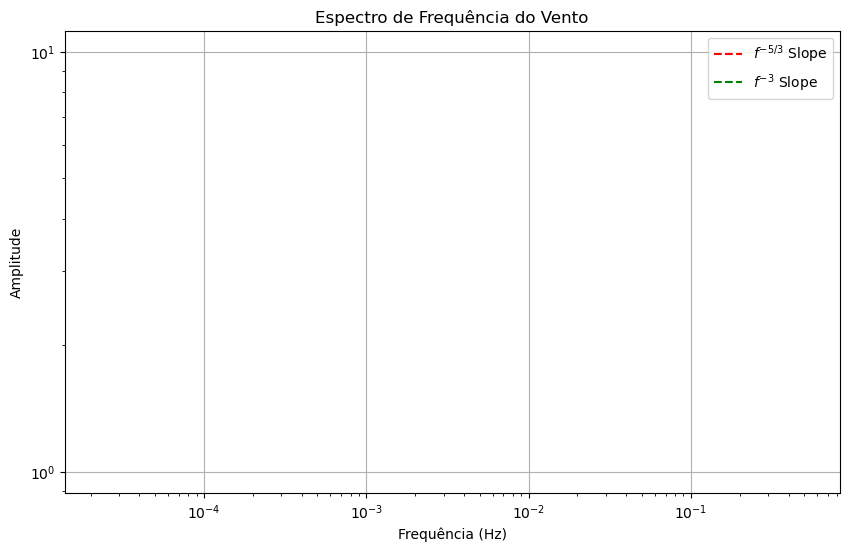

In [138]:
# Suponha que 'wind_time' e 'fft_result' já foram definidos como no contexto anterior
frequencies = np.fft.fftfreq(len(wind_time), 1.0)  # amostragem por hora
fft_result = np.fft.fft(wind_time)

# Define frequências positivas
positive_freqs = frequencies[:len(frequencies)//2]
positive_fft = np.abs(fft_result)[:len(frequencies)//2]

# Identificando f_L e f_t
f_L = 1 / 600  # Um pico a cada 10 minutos
f_t = 1 / 60  # Transição ocorre a cada minuto

# Inclinações para plotar
slope_53 = f_L * (positive_freqs / f_L)**(-5/3)
slope_3 = f_t * (positive_freqs / f_t)**(-3)

# Normalização para melhor visualização no plot
norm_factor = np.mean(positive_fft) / np.mean(slope_53)
slope_53 *= norm_factor
slope_3 *= norm_factor

# Plotar o espectro de frequência
plt.figure(figsize=(10, 6))
# plt.loglog(positive_freqs, positive_fft, label='Espectro de Frequência')
plt.loglog(positive_freqs, slope_53, 'r--', label='$f^{-5/3}$ Slope')
plt.loglog(positive_freqs, slope_3, 'g--', label='$f^{-3}$ Slope')
# plt.axvline(x=f_L, color='r', linestyle='--', label=f'$f_L$ = {f_L:.4f} Hz')
# plt.axvline(x=f_t, color='g', linestyle='--', label=f'$f_t$ = {f_t:.4f} Hz')
plt.title('Espectro de Frequência do Vento')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

In [141]:
np.nanmax(slope_3)

0.0

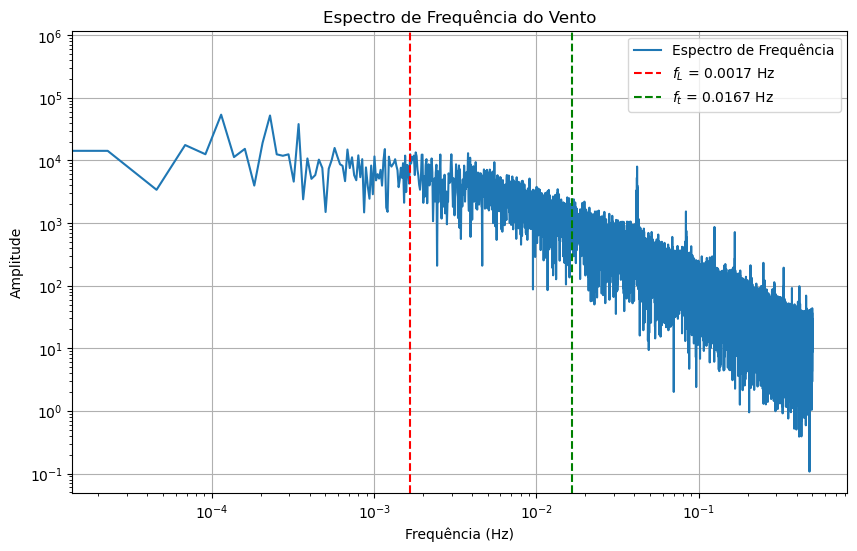

In [179]:
# Calculando a FFT
fft_result = np.fft.fft(wind_time)
# amostragem por hora
frequencies = np.fft.fftfreq(len(wind_time), 1.0)

# Identificando f_L e f_t (exemplo hipotético)
f_L = 1 / 600  # Um pico a cada 10 minutos
f_t = 1 / 60  # Transição ocorre a cada minuto

# Encontrar os índices para f_L e f_t
f_L_index = np.argmin(np.abs(frequencies - f_L))
f_t_index = np.argmin(np.abs(frequencies - f_t))

# Plotar o espectro de frequência
plt.figure(figsize=(10, 6))
plt.loglog(frequencies[:len(frequencies)//2], np.abs(fft_result)[:len(frequencies)//2], label='Espectro de Frequência')
plt.axvline(x=f_L, color='r', linestyle='--', label=f'$f_L$ = {f_L:.4f} Hz')
plt.axvline(x=f_t, color='g', linestyle='--', label=f'$f_t$ = {f_t:.4f} Hz')
plt.title('Espectro de Frequência do Vento')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

In [167]:
wind_time = vertical_profile_ds['wind_speed'].mean(dim='pressure_level').values
wind_pressure = vertical_profile_ds['wind_speed'].mean(dim='time').values

wind_time

array([11.75943808, 12.39908339, 13.14349835, ..., 12.91101021,
       13.08913643, 13.53152761])

In [89]:
def calculate_fL(ds, primary_dimension='pressure_level', secunday_dimension='time'):
    """
    Calculate the dominant spatial frequency (f_L) using Fast Fourier Transform (FFT).

    Parameters:
    ds (xarray.DataArray): Input data array containing wind measurements along a spatial dimension.
    dim (str): The dimension over which to perform the FFT (default is 'longitude').

    Returns:
    float: The dominant spatial frequency (f_L) in cycles per unit distance.

    Description:
    This function applies FFT to a DataArray to find the dominant frequency component in the specified dimension.
    It's useful for analyzing periodic patterns in meteorological data like wind speed or wind component fields.
    """
    # Calculate the mean over time if it's included, focusing on a purely spatial analysis
    ds = ds.mean(dim=secunday_dimension)

    # Apply FFT
    fft_result = np.fft.fft(ds.values)
    if primary_dimension == 'time':
        delta = ds[primary_dimension].values[1] - ds[primary_dimension].values[0]
        delta = (delta.astype('timedelta64[s]').astype(int) / 3600) / 3600
    else:
        delta = ds[primary_dimension].values[1] - ds[primary_dimension].values[0]
    frequencies = np.fft.fftfreq(len(ds), d=delta)

    # Find the index of the maximum amplitude in the positive frequencies part only
    positive_freqs = frequencies[:len(frequencies)//2]
    positive_fft = np.abs(fft_result)[:len(frequencies)//2]
    dominant_frequency_index = np.argmax(positive_fft)

    # Dominant spatial frequency
    f_L = abs(positive_freqs[dominant_frequency_index])

    return f_L



# Calculate the dominant spatial frequency for the u component of the wind
data = vertical_profile_ds['relative_humidity']
f_L = calculate_fL(data, primary_dimension='time', secunday_dimension='pressure_level')
print(f"The dominant spatial frequency f_L is: {f_L} cycles per unit of distance")

The dominant spatial frequency f_L is: 0.0 cycles per unit of distance


In [116]:
delta = ds[primary_dimension].values[1] - ds[primary_dimension].values[0]
# convert from nanoseconds to hours
delta = (delta.astype('timedelta64[s]').astype(int) / 3600) / 3600
delta

0.0002777777777777778

The dominant spatial frequency f_L is: 0.0000000000 cycles per unit of distance


Text(0, 0.5, 'Amplitude')

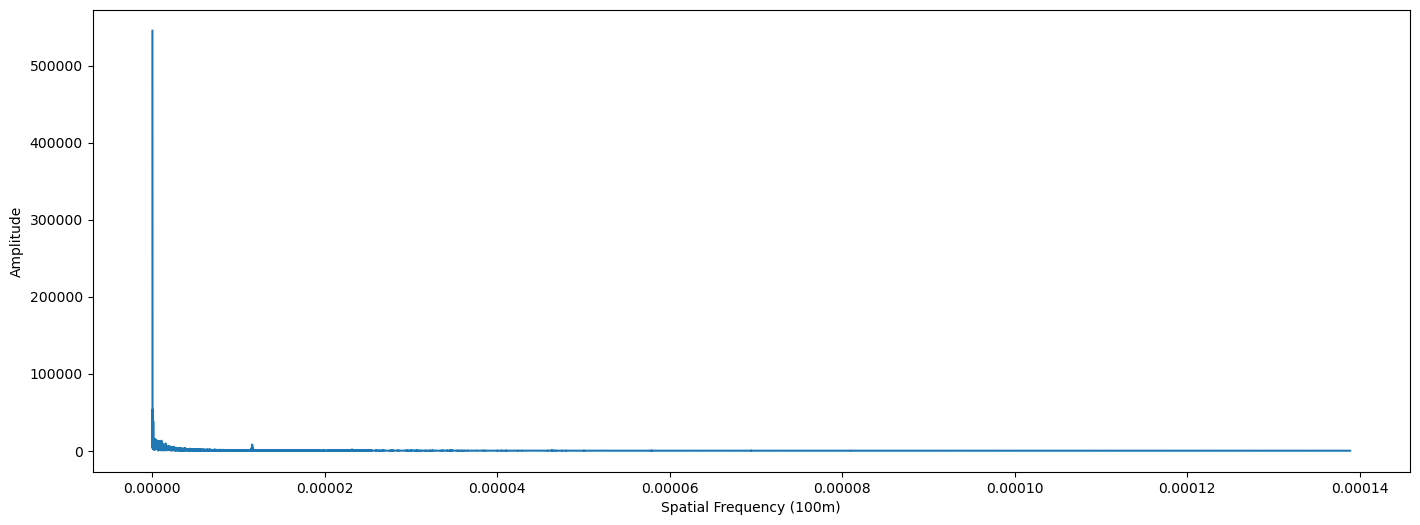

In [117]:
ds = vertical_profile_ds['wind_speed']

secunday_dimension = 'pressure_level'
primary_dimension = 'time'

ds = ds.mean(dim=secunday_dimension)

# Apply FFT
fft_result = np.fft.fft(ds.values)
if primary_dimension == 'time':
    delta = ds[primary_dimension].values[1] - ds[primary_dimension].values[0]
    delta = delta.astype('timedelta64[s]').astype(int)
else:
    delta = (delta.astype('timedelta64[s]').astype(int) / 3600) / 3600
frequencies = np.fft.fftfreq(len(ds), d=delta)

# Find the index of the maximum amplitude in the positive frequencies part only
positive_freqs = frequencies[:len(frequencies)//2]
positive_fft = np.abs(fft_result)[:len(frequencies)//2]
dominant_frequency_index = np.argmax(positive_fft)

# Dominant spatial frequency
f_L = abs(positive_freqs[dominant_frequency_index])

print(f"The dominant spatial frequency f_L is: {f_L:.10f} cycles per unit of distance")
plt.figure(figsize=(17, 6))
plt.plot(positive_freqs, positive_fft)
plt.xlabel('Spatial Frequency (100m)')
plt.ylabel('Amplitude')



In [88]:
# delta time in seconds


1.0

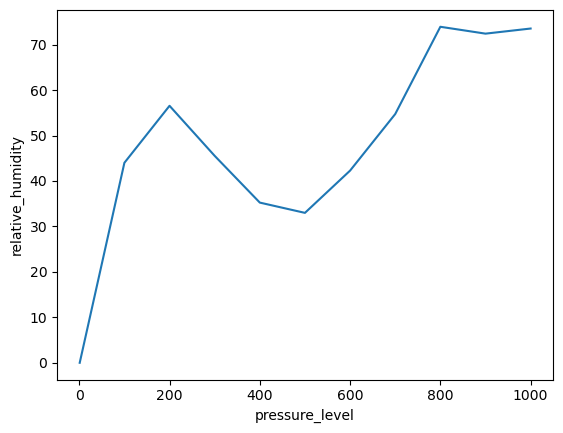

In [71]:
 vertical_profile_ds['relative_humidity'].mean(dim='time').plot()

In [40]:
vertical_profile_ds['wind_speed'].mean(dim='time')['pressure_level'][10] - vertical_profile_ds['wind_speed'].mean(dim='time')['pressure_level'][9]

<xarray.DataArray 'pressure_level' ()> Size: 8B
array(100)

### 4. Equação 4

$$
\sigma_T^2 = \int_{f_T}^{f_m} E(f) df
$$

**Explicação**:
- Calcula a variância da temperatura do ar **\(\sigma_T^2\)** a partir da densidade espectral de energia.
- **\(f_T\)** e **\(f_m\)** são as frequências de referência para as integrais.
- Importante para estimar a energia de flutuações de temperatura em diferentes escalas.


### 5. Equação 5

$$
E_l(f) = 0.125 C_T^2 f_l^{-5/3} \exp\left(-3 \ln^2 \left(\frac{f_l}{f_t}\right)\right)
$$

**Explicação**:
- Combina os aspectos das Equações 1 e 2 para fornecer um modelo mais abrangente da densidade espectral de energia.
- Utilizada para perfilar verticalmente o parâmetro de estrutura das flutuações do índice de refração do ar.


### 6. Equação 6

$$
\sigma_T^2(f_L) = a(f_L, V) \sigma_T^2
$$

**Explicação**:
- Relaciona a variância da temperatura a uma determinada escala **\(f_L\)** com a variância total **\(\sigma_T^2\)**, modulada por um fator **\(a\)** que depende da escala e da velocidade do vento.
- Ajuda a ajustar a contribuição de diferentes escalas para a variância total em função das condições locais.